# **MVP - Analisis de sentimientos en el futbol argentino**

**Un producto mínimo viable, o MVP, es un producto con las características suficientes para atraer a los primeros clientes adoptadores y validar una idea de producto en las etapas iniciales del ciclo de desarrollo del producto.**

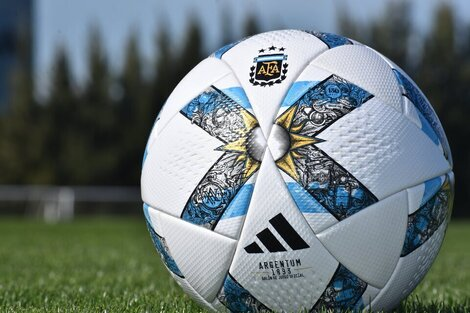



---



***PASO 1 - Problema de negocio***

El fútbol argentino genera una cantidad enorme de conversaciones en redes sociales siendo creciente el volumen de datos y las diversas opiniones, especialmente en Twitter. Cada partido, decisión arbitral, o jugada polémica provoca reacciones instantáneas de los hinchas. Sin embargo, estas opiniones quedan desorganizadas y sin análisis, haciendo difícil para clubes, medios de comunicación o marcas entender qué piensan los hinchas sobre ciertos temas, jugadores o eventos. Entonces, este MVP busca resolver ese problema, proporcionando una herramienta que analice automáticamente los sentimientos de los tweets relacionados al fútbol argentino. La idea es convertir ese "ruido" de comentarios en datos útiles para:


*   Identificar tendencias de opinión (por ejemplo, si un jugador es bien recibido
o no).

*   Entender mejor cómo reacciona la hinchada ante resultados, decisiones, o situaciones polémicas.


*   Ayudar a clubes, a la AFA y a marcas/sponsors a tomar decisiones informadas con estos datos










***PASO 2 - Base de datos***

**Libreria de pandas**

In [ ]:
import pandas as pd

In [ ]:
!pip install tweepy textblob matplotlib pandas

**Otras librerias a utilizar**

In [ ]:
import tweepy
from textblob import TextBlob
import matplotlib.pyplot as plt
import random
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import spacy
import seaborn as sns
from wordcloud import WordCloud
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from transformers import pipeline
import numpy as np
import unicodedata
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

Debido a que no cuento con el acceso necesario de un developer twitter premium, no puedo descargar tweets usando la API de twitter por ende voy a entrenar este modelo usando un csv armado mediante data sintetica pero con una base real de datos como lo es el dataset de 'FIFA world cup 2022 tweets'. Una de las proyecciones es luego de mostrar esta idea de negocio, poder conseguir a traves de alguna empresa o patrocinador el capital necesario para tener ese acceso.

**Datos sinteticos**

In [ ]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.6 MB/s eta 0:00:00


In [ ]:
from faker import Faker

random.seed(42)
Faker.seed(42)

fake = Faker('es_ES')

# Listas de clubes, jugadores y eventos
teams = ['Boca Juniors', 'River Plate', 'Racing Club', 'San Lorenzo', 'Independiente', 'Estudiantes', 'Gimnasia', 'Huracan', 'Velez', 'Central', 'Newells', 'Lanus', 'Banfield', 'Riestra', 'Independiente Rivadavia', 'Godoy Cruz', 'Platense', 'Tigre', 'Barracas', 'Sarmiento', 'Central Cordoba']
players = ['Cavani', 'Rojo', 'Borja', 'Acuña', 'Juanfer', 'Martinez', 'Muniain', 'Cuello', 'Lomonaco', 'Tarzia', 'Sosa', 'Piatti', 'De Blasis', 'Castro', 'Mazzanti', 'Wanchope', 'Romero', 'Gomez', 'Ruben', 'Malcorra', 'Ramirez', 'Garcia', 'Marcelino', 'Soler', 'Sepulveda', 'Gonzalez', 'Herrera', 'Spreen', 'Ham', 'Villa', 'Barrios', 'Rasmussen', 'Pellegrino', 'Campos', 'Cardozo', 'Maroni', 'Tapia', 'Bruera', 'Lopez', 'Gaitan', 'Atencio', 'Varaldo']
events = ['liga profesional', 'futbol argentino', 'el torneo local', 'la liga de los campeones del mundo']

# Frases de hinchas
hincha_phrases = [
    ("¡Dale {team}, hoy hay que ganar!", "POSITIVE"),
    ("{team} juega con el corazón, ¡qué huevos que pusieron hoy!", "POSITIVE"),
    ("{player} se corrió toda la cancha, impresionante lo de este flaco.", "POSITIVE"),
    ("El arbitraje un desastre, nos están robando.", "NEGATIVE"),
    ("{team} fue superior.", "POSITIVE"),
    ("¡Vamos {team}, siempre te banco!", "POSITIVE"),
    ("Hoy jugamos como nunca, ¡qué locura este equipo!", "POSITIVE"),
    ("El DT no puede seguir, no sabe lo que hace con {team}.", "NEGATIVE"),
    ("{player} está a otro nivel, ¡es el mejor del torneo!", "POSITIVE"),
    ("Son horribles los jugadores de {team}.", "NEGATIVE"),
    ("Lo que vi hoy con el árbitro beneficiando a {team} es una vergüenza.", "NEGATIVE"),
    ("Perdieron los burros de {team}, qué raro.", "NEGATIVE"),
    ("Basta de estos jugadores, no paran de perder.", "NEGATIVE"),
    ("La camiseta de {team} se tiene que transpirar.", "NEUTRAL"),
    ("Jajajaja hasta cuando va a seguir robando {team}.", "NEGATIVE"),
    ("{player} tiene licencia para pegar y agredir a todos.", "NEGATIVE"),
    ("No fue el mejor partido pero estoy conforme", "NEUTRAL"),
    ("Hoy no jugamos bien, pero al menos sumamos un punto.", "NEUTRAL"),
    ("Increíble lo de {player}, partido soñado.", "POSITIVE"),
    ("{team} está jugando como nunca, ¡espectáculo puro!", "POSITIVE"),
    ("Es un asco ver jugar a {team}, no tienen ideas.", "NEGATIVE"),
    ("Siempre confié en vos, {player}. ¡Qué partidazo!", "POSITIVE"),
    ("El gol que nos hicieron fue culpa del árbitro, vergonzoso.", "NEGATIVE"),
    ("Qué linda hinchada tiene {team}, siempre alentando.", "POSITIVE"),
    ("El arquero de {team} nos salvó el partido, ¡qué tapadas!", "POSITIVE"),
    ("El estadio vibró con ese gol de {player}.", "POSITIVE"),
    ("Lo que hizo el árbitro fue un papelón, claramente inclinado.", "NEGATIVE"),
    ("Hoy nos tocó perder, pero seguimos con fe.", "NEUTRAL"),
    ("¿Cómo puede seguir jugando {player}? Es un desastre.", "NEGATIVE"),
    ("El pase de {player} para el gol fue una delicia.", "POSITIVE"),
    ("Que se vayan todos, {team} no da para más.", "NEGATIVE"),
    ("La afición de {team} no se merece esto, qué mal rendimiento.", "NEGATIVE"),
    ("Gran debut de {player}, ¡se ganó la hinchada!", "POSITIVE"),
    ("Hoy demostramos carácter, ¡qué victoria de {team}!", "POSITIVE"),
    ("{event} fue emocionante, ambos equipos dejaron todo en la cancha.", "NEUTRAL"),
    ("El fútbol es injusto, hoy merecíamos ganar.", "NEUTRAL"),
    ("Lo de {player} es imperdonable, nos dejó con uno menos por nada.", "NEGATIVE"),
    ("Qué grande {team}, siempre jugando con garra.", "POSITIVE"),
    ("El penal que cobraron a favor de {team} no fue, pura mentira.", "NEGATIVE"),
    ("Estamos jugando con fuego, {team} necesita mejorar ya.", "NEGATIVE"),
    ("El esfuerzo de {player} hoy fue ejemplar.", "POSITIVE"),
    ("{team} tiene todo para ser campeón, si seguimos así no nos para nadie.", "POSITIVE"),
    ("No puedo creer lo que desperdició {player}, increíble.", "NEGATIVE"),
    ("Aplaudo el partido de {team}, aunque no se dio el resultado.", "NEUTRAL"),
    ("Esa chilena de {player} quedará en la historia, tremendo gol.", "POSITIVE"),
    ("Hay que sacar a {player}, ya no aporta al equipo.", "NEGATIVE"),
    ("La jugada colectiva que terminó en gol fue de manual, hermoso fútbol.", "POSITIVE"),
    ("La hinchada de {team} nunca para de alentar, ¡qué pasión!", "POSITIVE"),
    ("{player} es el alma del equipo, siempre rindiendo al máximo.", "POSITIVE"),
    ("Si seguimos así, {team} se va al descenso. Qué tristeza.", "NEGATIVE"),
    ("Se peleó hasta el final, pero no alcanzó.", "NEUTRAL"),
    ("Este equipo tiene futuro, los jóvenes de {team} están respondiendo.", "POSITIVE"),
    ("No entiendo cómo {team} no aprovechó las chances que tuvo.", "NEUTRAL"),
    ("Hoy fue una tarde negra, nada salió bien.", "NEGATIVE"),
    ("El pase de {player} fue mágico, ¡qué calidad tiene este crack!", "POSITIVE"),
    ("Esto es fútbol, a veces se gana y a veces se pierde.", "NEUTRAL"),
    ("{team} mostró actitud, eso es lo que queremos ver siempre.", "POSITIVE"),
    ("El planteo del DT fue muy defensivo, no arriesgamos nada.", "NEGATIVE"),
    ("Qué lindo es ver a {team} jugando así, puro espectáculo.", "POSITIVE"),
    ("Hoy no se ganó, pero dimos batalla hasta el final.", "NEUTRAL"),
    ("La falta de actitud de algunos jugadores de {team} es preocupante.", "NEGATIVE"),
    ("El gol de {player} nos dio vida en el torneo, ¡qué crack!", "POSITIVE"),
    ("Necesitamos más jugadores como {player}, ¡qué ejemplo de profesionalismo!", "POSITIVE"),
    ("El árbitro le regaló el partido a {team}, esto es un escándalo.", "NEGATIVE"),
    ("Estamos a nada de clasificar, ¡vamos {team}!", "POSITIVE"),
    ("Perder así duele, pero esto es parte del fútbol.", "NEUTRAL"),
    ("{player} es pura magia, qué privilegio verlo jugar.", "POSITIVE"),
    ("Este equipo no tiene alma, no se puede jugar así.", "NEGATIVE"),
    ("Con esfuerzo y dedicación, {team} puede lograr grandes cosas.", "POSITIVE"),

]

# Fuentes de tweets
tweet_sources = ['Twitter for iPhone', 'Twitter for Android', 'Twitter Web App']

def generate_random_tweet():
    template, sentiment = random.choice(hincha_phrases)
    team = random.choice(teams)
    player = random.choice(players)
    event = random.choice(events)
    tweet = template.format(team=team, player=player, event=event)
    return tweet, sentiment

# Dataset sintético
def generate_synthetic_dataset_with_sentiment(num_tweets=3000):
    synthetic_data = []
    for _ in range(num_tweets):
        tweet, sentiment = generate_random_tweet()
        synthetic_data.append({
            "Date Created": fake.date_time_this_year(),
            "Number of Likes": random.randint(0, 10000),
            "Source of Tweet": random.choice(tweet_sources),
            "Tweet": tweet,
            "Sentiment": sentiment
        })
    return pd.DataFrame(synthetic_data)

# Generar y guardar el dataset
synthetic_dataset = generate_synthetic_dataset_with_sentiment(num_tweets=3000)
output_path = 'tweets_futbol_argentino.csv'
synthetic_dataset.to_csv(output_path, index=False)

print(f"Dataset sintético con sentimientos generado en: {output_path}")

Dataset sintético con sentimientos generado en: tweets_futbol_argentino.csv


***PASO 3 - Limpieza de datos***

**Recursos NLTK**

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
file_path = 'tweets_futbol_argentino.csv'
data = pd.read_csv(file_path)

**Estructura del dataset**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date Created     3000 non-null   object
 1   Number of Likes  3000 non-null   int64 
 2   Source of Tweet  3000 non-null   object
 3   Tweet            3000 non-null   object
 4   Sentiment        3000 non-null   object
dtypes: int64(1), object(4)
memory usage: 117.3+ KB


In [ ]:
data.columns

Index(['Date Created', 'Number of Likes', 'Source of Tweet', 'Tweet',
       'Sentiment'],
      dtype='object')

**Nulos y valores duplicados**

In [ ]:
data.fillna({'Tweet': 'Sin contenido'}, inplace=True)

In [ ]:
data.drop_duplicates(subset='Tweet', inplace=True)

**Validacion de tipos de datos**

In [ ]:
data.dtypes

,0
Date Created,object
Number of Likes,int64
Source of Tweet,object
Tweet,object
Sentiment,object


'Date Created' al ser la columna fecha, debe estar en formato datetime

In [ ]:
data['Date Created'] = pd.to_datetime(data['Date Created'], errors='coerce')

Verifico si se cambio a datetime

In [ ]:
data.dtypes

,0
Date Created,datetime64[ns]
Number of Likes,int64
Source of Tweet,object
Tweet,object
Sentiment,object


***Paso 4 - Preprocesamiento del texto***

In [ ]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 15.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Stopwords
custom_stopwords = set(stopwords.words('spanish')).union({
    'el', 'la', 'los', 'las', 'de', 'en', 'que', 'para', 'del', 'con', 'un', 'una', 'es', 'ser', 'al', 'por', 'lo'
})
custom_stopwords.discard('no')

nlp = spacy.load('es_core_news_sm')

def clean_and_lemmatize_text(text):
    # Eliminar URLs, menciones y hashtags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|#\w+", '', text)

    # Eliminar caracteres no deseados y emojis
    text = re.sub(r'[^\w\s]', '', text)

    # Convertir a minúsculas
    text = text.lower()

    # Normalizar texto para eliminar tildes y caracteres raros
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

    # Tokenizar con spaCy
    doc = nlp(text)
    tokens = []
    for token in doc:
        # Si la palabra es importante ("no") o no está en las stopwords, mantenerla
        if token.text == 'no' or (token.is_alpha and token.text not in custom_stopwords):
            tokens.append(token.text)  # Usar la palabra original en lugar de la lematizada

    # Reconstruir el texto limpio
    return ' '.join(tokens)[:120]

# Aplicar preprocesamiento
data['Processed Tweet'] = data['Tweet'].apply(clean_and_lemmatize_text)

Le indico el parametro "no" debido a que podemos enfrentarnos a una posible confusión mas adelante con el modelo de ML porque capaz borra la palabra no y a la hora de clasificar el sentimiento, algo que era negativo pasa a ser positivo. Ademas elimino articulos

Creo una columna 'Tweet Lenght' la cual me dice la cantidad de caracteres de un tweet

In [ ]:
data['Tweet Length'] = data['Tweet'].apply(len)

In [ ]:
data.columns

Index(['Date Created', 'Number of Likes', 'Source of Tweet', 'Tweet',
       'Sentiment', 'Processed Tweet', 'Tweet Length'],
      dtype='object')

Guardo este nuevo csv limpio, preprocesado y con columnas nuevas pero cambiando el orden de las columnas para mayor claridad

In [ ]:
data = data[['Date Created', 'Number of Likes', 'Source of Tweet', 'Tweet', 'Tweet Length', 'Processed Tweet', 'Sentiment']]

# Guardar el DataFrame
data.to_csv('tweets_futbol_argentino_cleaned.csv', index=False)
print("Dataset limpio guardado como: tweets_futbol_argentino_cleaned.csv")

Dataset limpio guardado como: tweets_futbol_argentino_cleaned.csv


***PASO 5 - EDA***

In [ ]:
data.head()

,Date Created,Number of Likes,Source of Tweet,Tweet,Tweet Length,Processed Tweet,Sentiment
0,2024-08-11 14:51:19.078300,3657,Twitter for iPhone,Jajajaja hasta cuando va a seguir robando Boca...,55,jajajaja va seguir robando boca juniors,NEGATIVE
1,2024-01-09 17:55:15.550753,520,Twitter for iPhone,La camiseta de Tigre se tiene que transpirar.,45,camiseta tigre transpirar,NEUTRAL
2,2024-04-06 04:23:02.197788,9195,Twitter for iPhone,"Perdieron los burros de Gimnasia, qué raro.",43,perdieron burros gimnasia raro,NEGATIVE
3,2024-03-19 01:27:31.513457,106,Twitter for iPhone,"Hoy fue una tarde negra, nada salió bien.",41,hoy tarde negra salio bien,NEGATIVE
4,2024-09-14 13:22:16.557532,3527,Twitter for Android,"El pase de Gomez fue mágico, ¡qué calidad tien...",59,pase gomez magico calidad crack,POSITIVE


**1. Distribución del número de likes**

¿Cómo se distribuyen los likes entre los tweets?

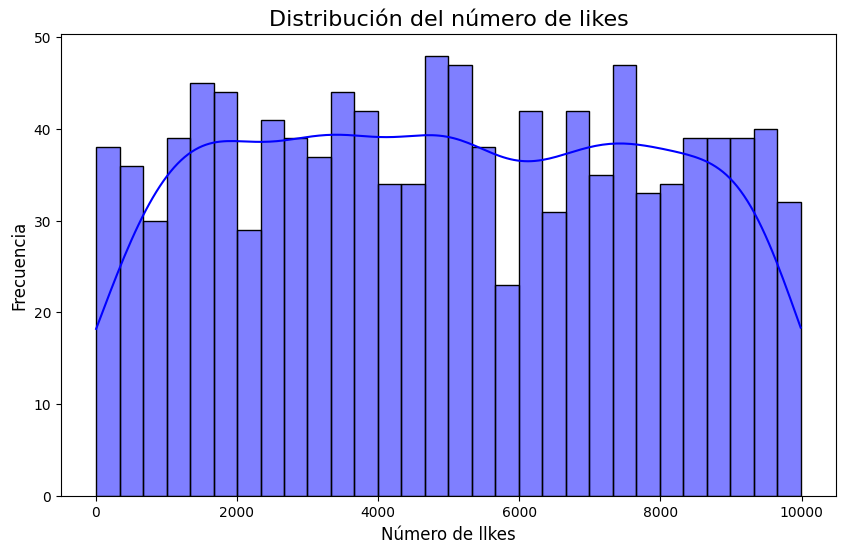

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Number of Likes'], bins=30, kde=True, color="blue")
plt.title('Distribución del número de likes', fontsize=16)
plt.xlabel('Número de llkes', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

**2. Distribución de la longitud de los tweets**

¿Cantidad de caracteres de los tweets preprocesados?

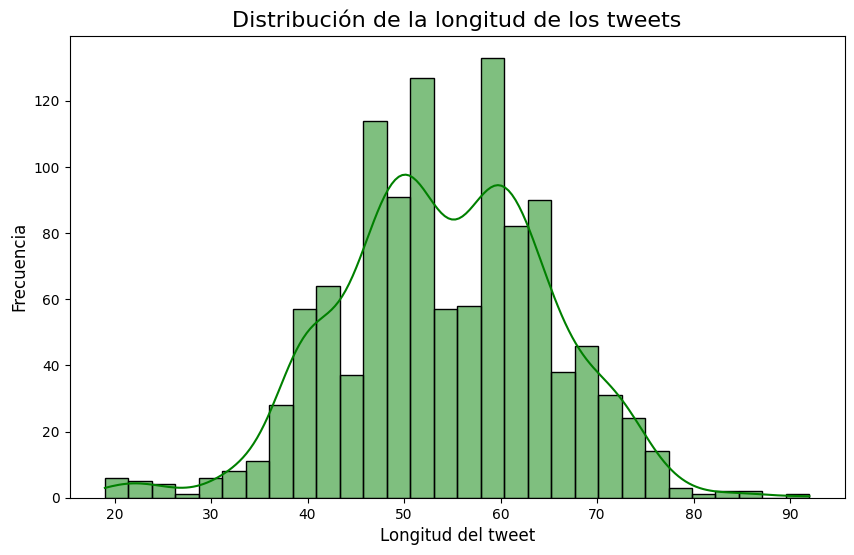

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Tweet Length'], bins=30, kde=True, color="green")
plt.title('Distribución de la longitud de los tweets', fontsize=16)
plt.xlabel('Longitud del tweet', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

**3. Relación entre longitud del tweet y likes**

¿Que prefieren las personas, tweets largos o cortos?

**Insight:** Identificar si hay una tendencia clara entre la longitud del tweet y su popularidad.

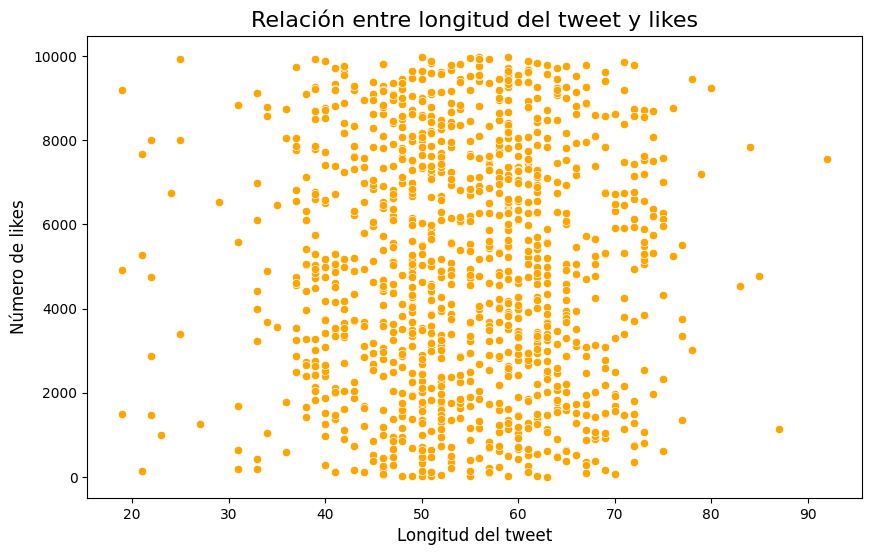

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Tweet Length'], y=data['Number of Likes'], color="orange")
plt.title('Relación entre longitud del tweet y likes', fontsize=16)
plt.xlabel('Longitud del tweet', fontsize=12)
plt.ylabel('Número de likes', fontsize=12)
plt.show()

**4. Palabras más frecuentes**

¿Palabras más comunes en los tweets?

**Insight:** Identificar las palabras clave

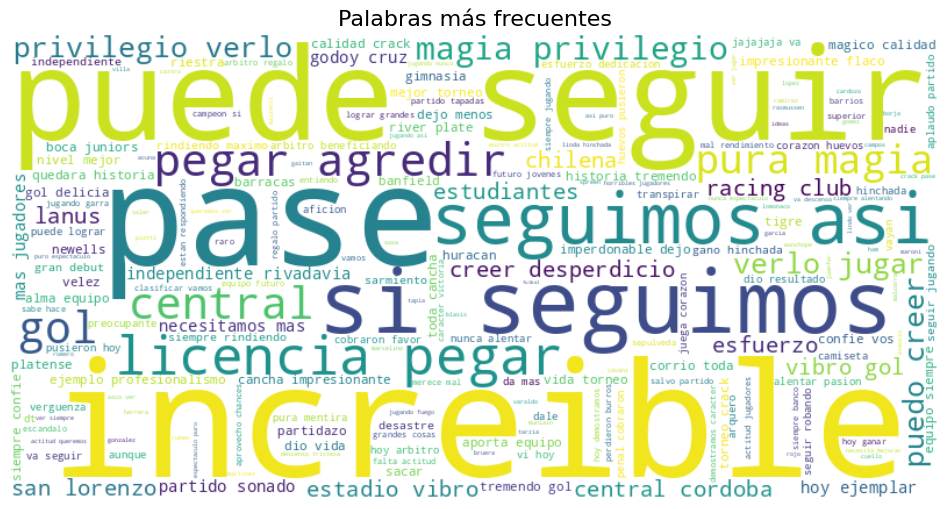

In [ ]:
all_words = ' '.join(data['Processed Tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras más frecuentes', fontsize=16)
plt.show()

**5. Distribución de Tweets a lo Largo del Tiempo**

Ver cómo varía el volumen de tweets por día

**Insight:** Identificar picos de actividad relacionados con eventos importantes

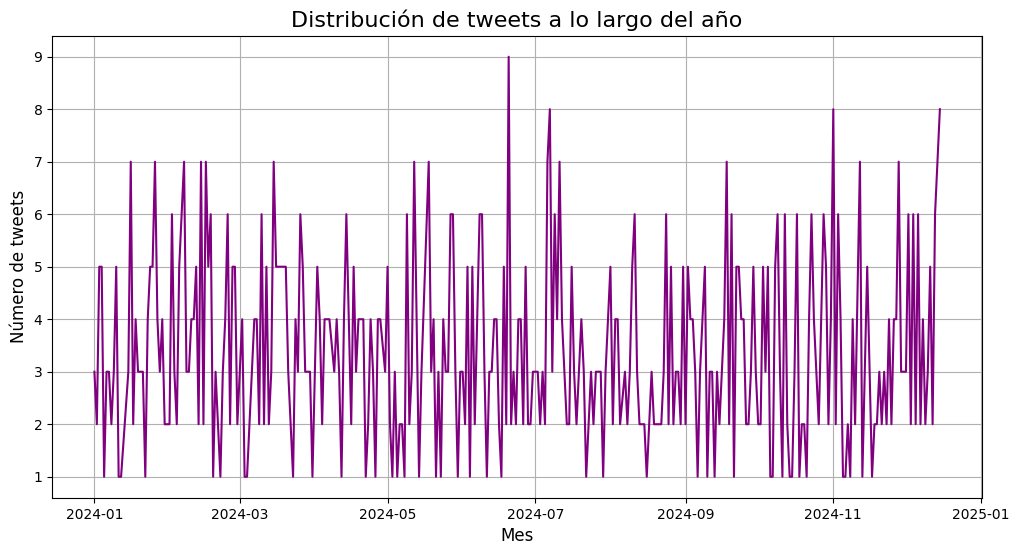

In [ ]:
tweets_per_mes = data.groupby(data['Date Created'].dt.date).size()

plt.figure(figsize=(12, 6))
tweets_per_mes.plot(kind='line', color='purple')
plt.title('Distribución de tweets a lo largo del año', fontsize=16)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Número de tweets', fontsize=12)
plt.grid()
plt.show()

***PASO 6 - EDA sentimientos***

Antes de realizar graficos en cuanto a los sentimientos, considero crear una paleta de colores personalizadas simil a un semaforo porque la parte visual es muy importante a la hora de mostrar algo. El color verde sera para los sentimientos positivos, el amarillo para los neutrales y el rojo para los negativos

In [ ]:
custom_palette = {
    'NEUTRAL': '#FFD700',  # Amarillo
    'POSITIVE': '#228B22',  # Verde
    'NEGATIVE': '#FF4500'  # Rojo
}

**1. Distribución de sentimientos**

<ipython-input-27-df0587f736fd>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Sentiment', palette=custom_palette, order=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])


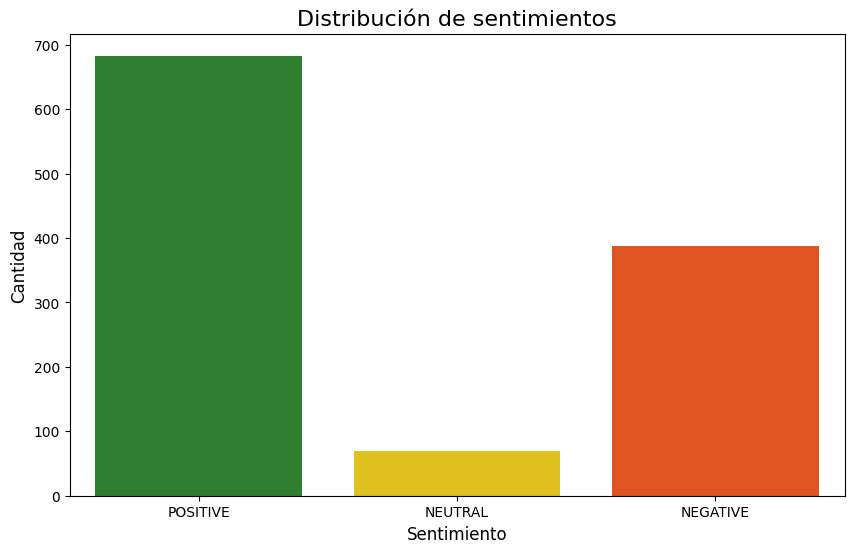

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Sentiment', palette=custom_palette, order=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
plt.title('Distribución de sentimientos', fontsize=16)
plt.xlabel('Sentimiento', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.show()

**2. Sentimientos por número de likes**

<ipython-input-28-71fbdea1f021>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Sentiment', y='Number of Likes', palette=custom_palette, order=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])


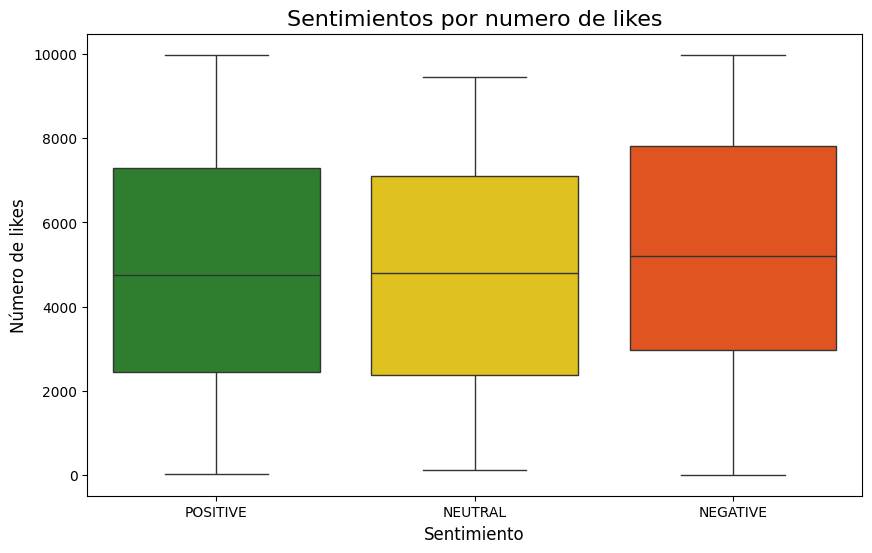

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Sentiment', y='Number of Likes', palette=custom_palette, order=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
plt.title('Sentimientos por numero de likes', fontsize=16)
plt.xlabel('Sentimiento', fontsize=12)
plt.ylabel('Número de likes', fontsize=12)
plt.show()

**3. Sentimientos a lo largo del tiempo**

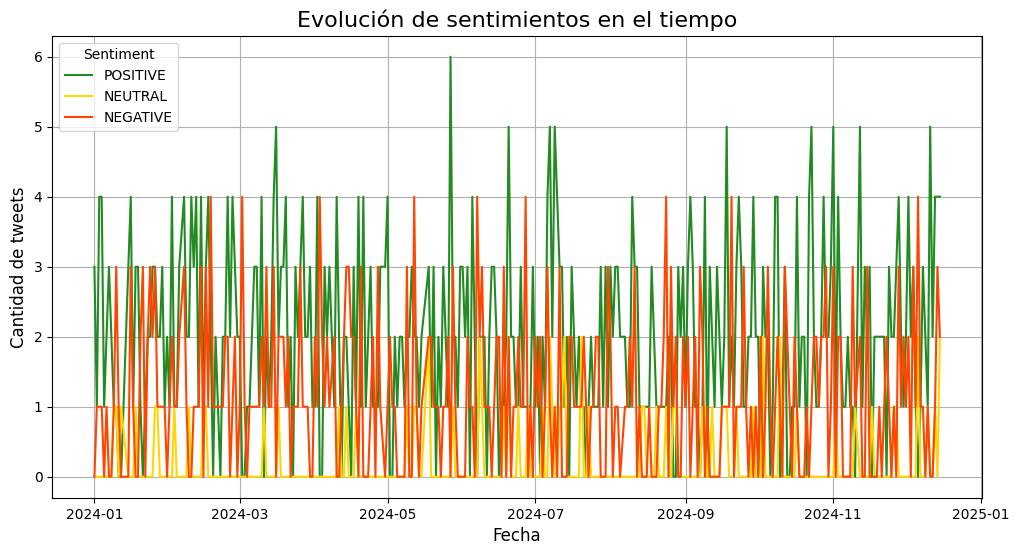

In [ ]:
sentiments_over_time = data.groupby([data['Date Created'].dt.date, 'Sentiment']).size().unstack(fill_value=0)

# Ordenar las columnas para que coincidan con la paleta definida
sentiments_over_time = sentiments_over_time[['POSITIVE', 'NEUTRAL', 'NEGATIVE']]

# Gráfico de evolución de sentimientos
sentiments_over_time.plot(kind='line', figsize=(12, 6), color=[
    custom_palette['POSITIVE'],
    custom_palette['NEUTRAL'],
    custom_palette['NEGATIVE']
])
plt.title('Evolución de sentimientos en el tiempo', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cantidad de tweets', fontsize=12)
plt.grid()
plt.show()

**4. Nube de palabras por sentimiento**

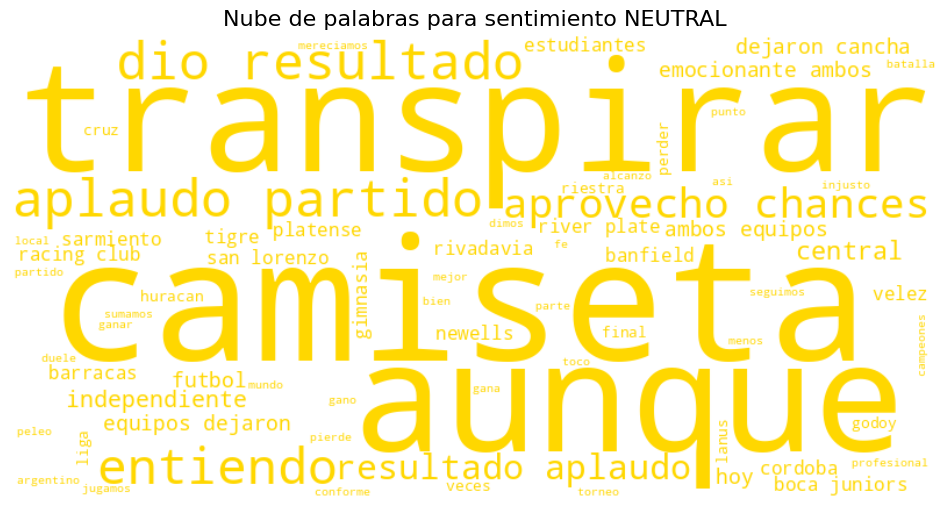

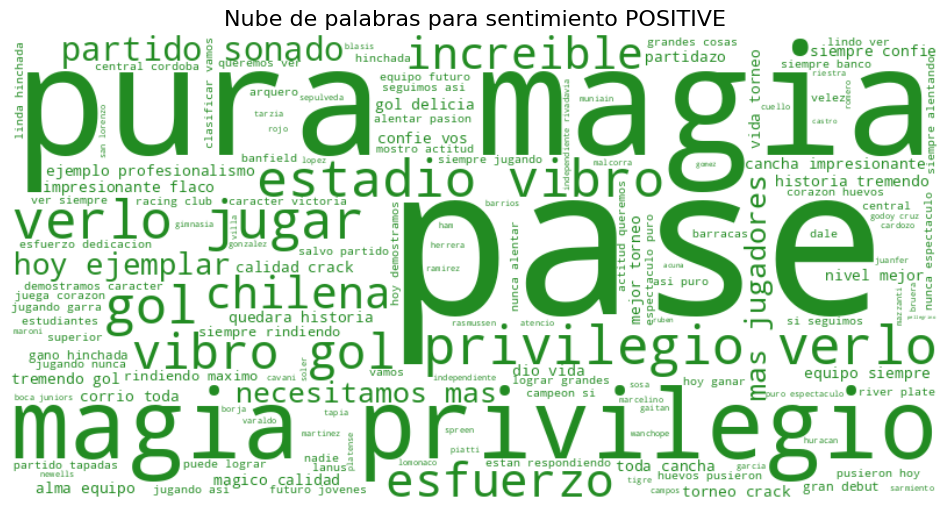

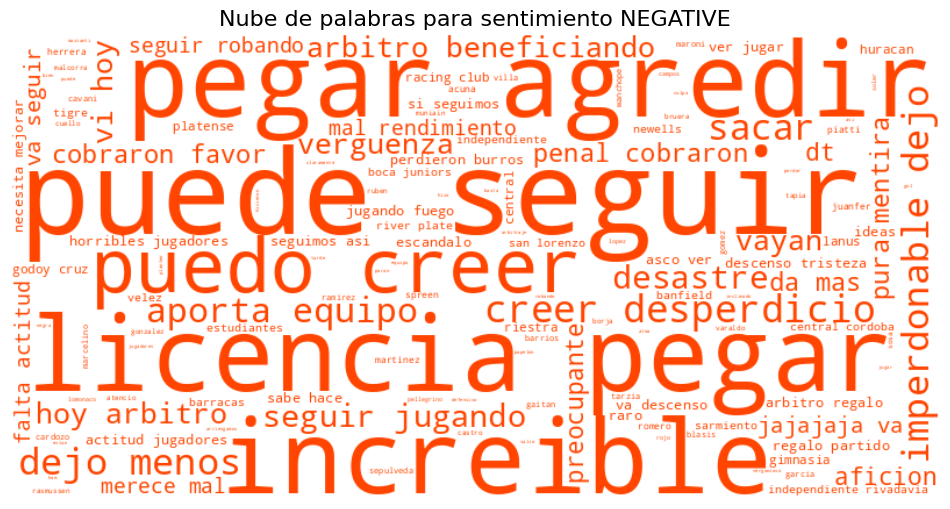

In [ ]:
for sentiment, color in custom_palette.items():
    sentiment_words = ' '.join(data[data['Sentiment'] == sentiment]['Processed Tweet'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=None, color_func=lambda *args, **kwargs: color).generate(sentiment_words)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de palabras para sentimiento {sentiment}', fontsize=16)
    plt.show()

***PASO 7 - Analisis de sentimientos con machine learning***

Una vez que tenemos un analisis de sentimientos simple, la idea es realizar un modelo de analisis de sentimiento mas complejo utilizando machine learning y luego comparar este resultado con el analisis simple previamente realizado y ver cual es el modelo ideal para utilizar en el producto de datos

La idea es la implementacion de un transformer. Considero que es una buena elección ya que es uno de los métodos más modernos que llaman la atencion y generan mas valor en este contexto que los metodos de machine learning tradicionales como pueden ser la regresion logistica, random forest, naive bayes, etc.

**Transformer**

In [ ]:
!pip install transformers torch torchvision torchaudio

In [ ]:
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Etiquetas
star_mapping = {
    '1 star': 'NEGATIVE',
    '2 stars': 'NEGATIVE',
    '3 stars': 'NEUTRAL',
    '4 stars': 'POSITIVE',
    '5 stars': 'POSITIVE'
}

# Función para analizar sentimientos con mapeo
def analyze_sentiment_with_mapping(text):
    try:
        result = sentiment_analyzer(text)[0]  # Análisis del texto
        mapped_label = star_mapping.get(result['label'], 'ERROR')  # Mapear etiqueta
        return mapped_label
    except Exception as e:
        print(f"Error al procesar el tweet: {e}")
        return "ERROR"

# Aplicar análisis de sentimientos a los tweets procesados
data['Transformer_Sentiment'] = data['Processed Tweet'].apply(analyze_sentiment_with_mapping)

# Guardar los resultados
output_path = 'tweets_futbol_argentino_with_transformer_sentiments.csv'
data.to_csv(output_path, index=False)
print(f"Análisis de sentimientos guardado en: {output_path}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Análisis de sentimientos guardado en: tweets_futbol_argentino_with_transformer_sentiments.csv


***PASO 8 - Comparativa analisis simple vs ML***

La idea es realizar una comparativa que demuestre si hay grandes diferencias entre los analisis

**Unión datasets**

In [ ]:
simple_data = pd.read_csv('tweets_futbol_argentino_cleaned.csv')
transformer_data = pd.read_csv('tweets_futbol_argentino_with_transformer_sentiments.csv')

comparison_data = simple_data[['Processed Tweet', 'Sentiment']].merge(
    transformer_data[['Processed Tweet', 'Transformer_Sentiment']],
    on='Processed Tweet',
    how='inner'
)

print(comparison_data.head())

                           Processed Tweet Sentiment Transformer_Sentiment
0  jajajaja va seguir robando boca juniors  NEGATIVE              NEGATIVE
1                camiseta tigre transpirar   NEUTRAL              NEGATIVE
2           perdieron burros gimnasia raro  NEGATIVE              NEGATIVE
3               hoy tarde negra salio bien  NEGATIVE              POSITIVE
4          pase gomez magico calidad crack  POSITIVE              POSITIVE


Los uno mediante la columna processed tweet y luego comparo masomenos con las primeras 5 filas en primera instancia

**Diferencias**

<ipython-input-34-d1dce07bc8c8>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=comparison_data, palette=custom_palette, order=sentiment_order)
<ipython-input-34-d1dce07bc8c8>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Transformer_Sentiment', data=comparison_data, palette=custom_palette, order=sentiment_order)


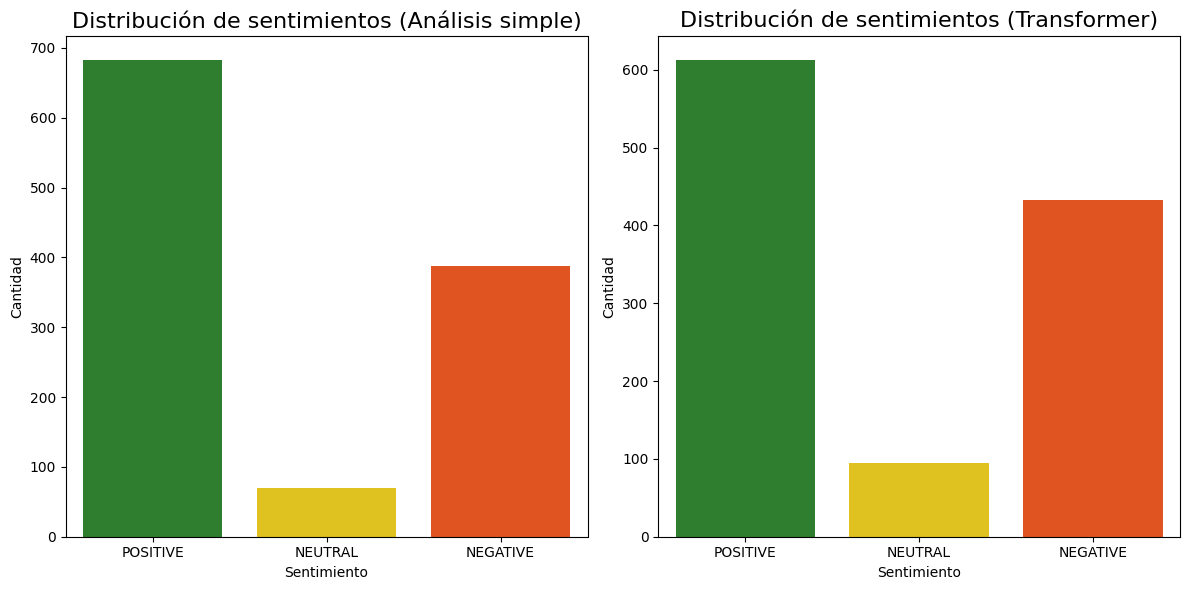

In [ ]:
sentiment_order = ['POSITIVE', 'NEUTRAL', 'NEGATIVE']

plt.figure(figsize=(12, 6))

# Análisis simple
plt.subplot(1, 2, 1)
sns.countplot(x='Sentiment', data=comparison_data, palette=custom_palette, order=sentiment_order)
plt.title('Distribución de sentimientos (Análisis simple)', fontsize=16)
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')

# Transformer
plt.subplot(1, 2, 2)
sns.countplot(x='Transformer_Sentiment', data=comparison_data, palette=custom_palette, order=sentiment_order)
plt.title('Distribución de sentimientos (Transformer)', fontsize=16)
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')

plt.tight_layout()
plt.show()

**Coincidencias**

<ipython-input-35-e99a124ef6ce>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=match_counts.index, y=match_counts.values, palette=['#FF4500', '#228B22'])


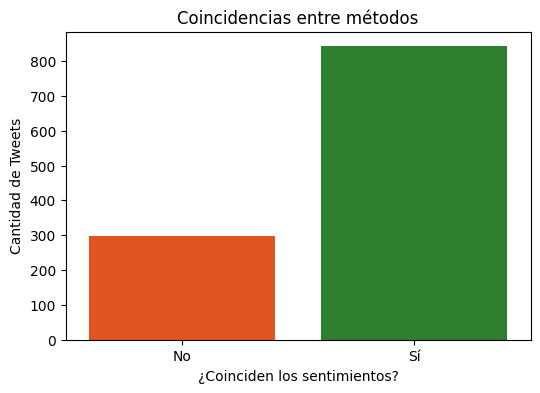

In [ ]:
comparison_data['Match'] = comparison_data['Sentiment'] == comparison_data['Transformer_Sentiment']

# Coincidencias y diferencias
match_counts = comparison_data['Match'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=match_counts.index, y=match_counts.values, palette=['#FF4500', '#228B22'])
plt.title('Coincidencias entre métodos')
plt.xlabel('¿Coinciden los sentimientos?')
plt.ylabel('Cantidad de Tweets')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

**% Coincidencia y diferencia**

In [ ]:
# %
total_tweets = len(comparison_data)
matches = comparison_data['Match'].sum()
differences = total_tweets - matches

match_percentage = (matches / total_tweets) * 100
difference_percentage = (differences / total_tweets) * 100

# Resultados
print(f"Total de Tweets analizados: {total_tweets}")
print(f"Coincidencias: {matches} ({match_percentage:.2f}%)")
print(f"Diferencias: {differences} ({difference_percentage:.2f}%)")

Total de Tweets analizados: 1141
Coincidencias: 842 (73.79%)
Diferencias: 299 (26.21%)


*Comparacion*

Preparacion de los datos

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


data = pd.read_csv('tweets_futbol_argentino_cleaned.csv')

# Metricas
def calculate_metrics(true_labels, predicted_labels, model_name):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

**1. BERT**

In [ ]:
bert_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Etiquetas
bert_mapping = {
    '1 star': 'NEGATIVE',
    '2 stars': 'NEGATIVE',
    '3 stars': 'NEUTRAL',
    '4 stars': 'POSITIVE',
    '5 stars': 'POSITIVE'
}

def bert_sentiment(text):
    try:
        result = bert_model(text)[0]
        return bert_mapping.get(result['label'], 'NEUTRAL')
    except:
        return 'NEUTRAL'

data['BERT Sentiment'] = data['Processed Tweet'].apply(bert_sentiment)

# Métricas
bert_metrics = calculate_metrics(data['Sentiment'], data['BERT Sentiment'], "BERT")


BERT Metrics:
Accuracy: 0.7379
Precision: 0.7590
Recall: 0.7379
F1 Score: 0.7459


**2. VADER**

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

vader_analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    scores = vader_analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return 'POSITIVE'
    elif compound <= -0.05:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

data['VADER Sentiment'] = data['Processed Tweet'].apply(vader_sentiment)

# Métricas
vader_metrics = calculate_metrics(data['Sentiment'], data['VADER Sentiment'], "VADER")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...



VADER Metrics:
Accuracy: 0.1735
Precision: 0.5281
Recall: 0.1735
F1 Score: 0.2055


**3. TextBlob**

In [ ]:
from textblob import TextBlob

def textblob_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'POSITIVE'
    elif polarity < -0.1:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

data['TextBlob Sentiment'] = data['Processed Tweet'].apply(textblob_sentiment)

# Métricas
textblob_metrics = calculate_metrics(data['Sentiment'], data['TextBlob Sentiment'], "TextBlob")


TextBlob Metrics:
Accuracy: 0.0771
Precision: 0.6024
Recall: 0.0771
F1 Score: 0.0379


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Comparativa de los 3 modelos

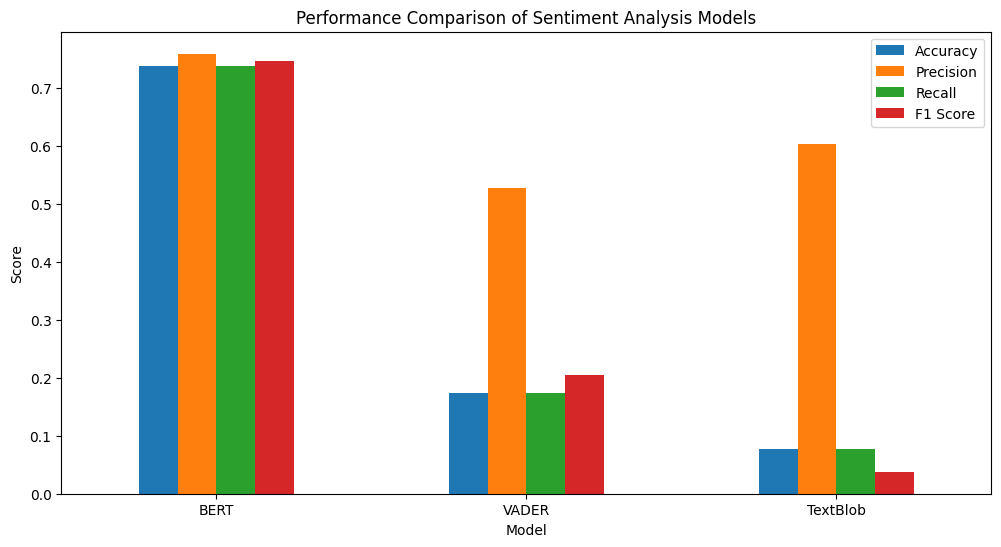

In [ ]:
metrics_df = pd.DataFrame({
    'Model': ['BERT', 'VADER', 'TextBlob'],
    'Accuracy': [bert_metrics[0], vader_metrics[0], textblob_metrics[0]],
    'Precision': [bert_metrics[1], vader_metrics[1], textblob_metrics[1]],
    'Recall': [bert_metrics[2], vader_metrics[2], textblob_metrics[2]],
    'F1 Score': [bert_metrics[3], vader_metrics[3], textblob_metrics[3]],
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 6), title="Performance Comparison of Sentiment Analysis Models")
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

***PASO 9 - Generacion de nuevos tweets***

Quiero aumentar la cantidad de tweets para demostrar que si bien nos encontramos con diferencias en la clasificacion, a medida que se agregan tweets el modelo mejora en comparacion a su predecesor

In [ ]:
fake = Faker('es_ES')

# Mismos equipos pero diferentes jugadores para entrenarlo con datos diferentes
teams = ['Boca Juniors', 'River Plate', 'Racing Club', 'San Lorenzo', 'Independiente', 'Estudiantes', 'Gimnasia', 'Huracan', 'Velez', 'Central', 'Newells', 'Lanus', 'Banfield', 'Riestra', 'Independiente Rivadavia', 'Godoy Cruz', 'Platense', 'Tigre', 'Barracas', 'Sarmiento', 'Central Cordoba']
players = ['Merentiel', 'Pol', 'Colidio', 'Solari', 'Maravilla', 'Martirena', 'Romaña', 'Barrios', 'Mancuello', 'Marcone', 'Enzo', 'Carrillo', 'Max', 'Castillo', 'Ramirez', 'Alarcon', 'Thiago', 'Elias', 'Campaz', 'Copetti', 'Silvetti', 'Banega', 'Bou', 'Peña', 'Rodriguez', 'Soraire', 'Celiz', 'Fernandez', 'Cardillo', 'Abecasis', 'Abrego', 'Arce', 'Suso', 'Mainero', 'Ponce', 'Paz', 'Rosane', 'Gonzalez', 'Hauche', 'Gho', 'Montoya', 'Bogarin']
events = ['Futbol argentino']

# Tweets nuevos
new_phrases = [
    ("{team} jugó como nunca, ¡qué partidazo!", "POSITIVE"),
    ("{team} dio todo en la cancha, ¡gran esfuerzo colectivo!", "POSITIVE"),
    ("Es frustrante ver cómo {player} siempre falla en momentos clave.", "NEGATIVE"),
    ("Lo del árbitro favoreciendo a {team} ya es costumbre.", "NEGATIVE"),
    ("{event} será una batalla, pero confío en que {team} pueda ganar.", "NEUTRAL"),
    ("Otra actuación increíble de {player}, ¡está en su mejor momento!", "POSITIVE"),
    ("La defensa de {team} es un chiste, así no se puede competir.", "NEGATIVE"),
    ("Qué lindo ver a {team} jugar así, puro espectáculo.", "POSITIVE"),
    ("{player} debe salir del equipo, no aporta nada en el juego.", "NEGATIVE"),
    ("Un empate aburrido, {team} no mostró nada especial hoy.", "NEUTRAL"),
    ("La hinchada de {team} nunca decepciona, ¡qué energía transmiten!", "POSITIVE"),
    ("No entiendo cómo {player} sigue siendo titular, es un desastre.", "NEGATIVE"),
    ("El pase de {player} fue impresionante, ¡qué calidad tiene este jugador!", "POSITIVE"),
    ("Hoy {team} dio una lección de fútbol, así se juega.", "POSITIVE"),
    ("Otra derrota sin ideas, el DT de {team} no está haciendo bien las cosas.", "NEGATIVE"),
    ("{event} será clave para el futuro del torneo, ¡a darlo todo!", "NEUTRAL"),
    ("Los jóvenes de {team} están rindiendo muy bien, gran proyección.", "POSITIVE"),
    ("Otra vez el arbitraje perjudicó a {team}, esto es inaceptable.", "NEGATIVE"),
    ("Lo de {player} hoy fue admirable, un jugador de otra categoría.", "POSITIVE"),
    ("Hoy fue un partido sin emociones, esperaba más de ambos equipos.", "NEUTRAL"),
    ("El DT de {team} sigue sin encontrar la fórmula, cada vez estamos peor.", "NEGATIVE"),

]

def generate_new_tweet():
    phrase, sentiment = random.choice(new_phrases)
    team = random.choice(teams)
    player = random.choice(players)
    event = random.choice(events)
    tweet = phrase.format(team=team, player=player, event=event)
    return {
        "Date Created": fake.date_time_this_year(),
        "Number of Likes": random.randint(10, 500),
        "Source of Tweet": random.choice(['Twitter for iPhone', 'Twitter for Android', 'Twitter Web App']),
        "Tweet": tweet,
        "Sentiment": sentiment
    }

# Generar 100 tweets nuevos
new_tweets = [generate_new_tweet() for _ in range(100)]
new_tweets_df = pd.DataFrame(new_tweets)

new_tweets_df.to_csv('tweets_futbol_argentino_2_tanda.csv', index=False)
print("Nuevos tweets generados y guardados en: tweets_futbol_argentino_2_tanda.csv")

print(new_tweets_df.head())

Nuevos tweets generados y guardados en: tweets_futbol_argentino_2_tanda.csv
                Date Created  Number of Likes      Source of Tweet  \
0 2024-10-29 04:15:51.385374              135      Twitter Web App   
1 2024-08-15 15:48:12.413219              145      Twitter Web App   
2 2024-08-28 07:33:54.650862              479   Twitter for iPhone   
3 2024-02-26 21:13:48.183053              322  Twitter for Android   
4 2024-01-26 18:40:02.472730              319   Twitter for iPhone   

                                               Tweet Sentiment  
0  Otra vez el arbitraje perjudicó a Independient...  NEGATIVE  
1  El pase de Abrego fue impresionante, ¡qué cali...  POSITIVE  
2  Un empate aburrido, Sarmiento no mostró nada e...   NEUTRAL  
3  Hoy fue un partido sin emociones, esperaba más...   NEUTRAL  
4  Futbol argentino será una batalla, pero confío...   NEUTRAL  


**Limpieza y preprocesamiento**

In [ ]:
file_path = 'tweets_futbol_argentino_2_tanda.csv'
new_data = pd.read_csv(file_path)

# Nulos y duplicados
new_data.fillna({'Tweet': 'Sin contenido'}, inplace=True)
new_data.drop_duplicates(subset='Tweet', inplace=True)

# Date Created' a datetime
new_data['Date Created'] = pd.to_datetime(new_data['Date Created'], errors='coerce')

# Stopwords
custom_stopwords = set(stopwords.words('spanish')).union({
    'el', 'la', 'los', 'las', 'de', 'en', 'que', 'para', 'del', 'con', 'un', 'una', 'es', 'ser', 'al', 'por', 'lo'
})
custom_stopwords.discard('no')
nlp = spacy.load('es_core_news_sm')

# Preprocesamiento
def clean_and_lemmatize_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Eliminar URLs
    text = re.sub(r"@\w+|#\w+", '', text)  # Eliminar menciones y hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar caracteres especiales
    text = text.lower()  # Convertir a minúsculas
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

    # Tokenizar y filtrar con spaCy
    doc = nlp(text)
    tokens = [
        token.text for token in doc
        if token.is_alpha and (token.text not in custom_stopwords or token.text == 'no')
    ]
    return ' '.join(tokens)[:120]

# Aplicar preprocesamiento a la columna 'Tweet'
new_data['Processed Tweet'] = new_data['Tweet'].apply(clean_and_lemmatize_text)

# Crear la columna con la cant de caracteres
new_data['Tweet Length'] = new_data['Tweet'].apply(len)

new_data = new_data[['Date Created', 'Number of Likes', 'Source of Tweet', 'Tweet', 'Tweet Length', 'Processed Tweet', 'Sentiment']]

output_file = 'tweets_futbol_argentino_2_tanda_cleaned.csv'
new_data.to_csv(output_file, index=False, encoding='utf-8')
print(f"Dataset limpio guardado como: {output_file}")

Dataset limpio guardado como: tweets_futbol_argentino_2_tanda_cleaned.csv


**Clasificación de tweets nuevos**

In [ ]:
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Diccionario para mapear etiquetas de estrellas a sentimientos
star_mapping = {
    '1 star': 'NEGATIVE',
    '2 stars': 'NEGATIVE',
    '3 stars': 'NEUTRAL',
    '4 stars': 'POSITIVE',
    '5 stars': 'POSITIVE'
}

def classify_with_transformer(text):
    try:
        result = sentiment_analyzer(text)[0]
        return star_mapping.get(result['label'], 'ERROR')  # Mapear las etiquetas
    except Exception as e:
        print(f"Error procesando tweet: {e}")
        return "ERROR"

new_cleaned_data_path = 'tweets_futbol_argentino_2_tanda_cleaned.csv'
new_cleaned_data = pd.read_csv(new_cleaned_data_path)

new_cleaned_data['Transformer_Sentiment'] = new_cleaned_data['Processed Tweet'].apply(classify_with_transformer)

# Guardar el dataset clasificado
classified_output_path = 'tweets_futbol_argentino_2_tanda_with_transformer_sentiments.csv'
new_cleaned_data.to_csv(classified_output_path, index=False, encoding='utf-8')
print(f"Tweets clasificados guardados en: {classified_output_path}")

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Tweets clasificados guardados en: tweets_futbol_argentino_2_tanda_with_transformer_sentiments.csv


**Evaluación**


Métricas para Dataset Original:

Accuracy: 0.74
Precision: 0.76
Recall: 0.74
F1 Score: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.73      0.69       388
           1       0.28      0.39      0.33        70
           2       0.87      0.78      0.82       683

    accuracy                           0.74      1141
   macro avg       0.60      0.63      0.61      1141
weighted avg       0.76      0.74      0.75      1141


Métricas para Dataset Combinado:

Accuracy: 0.74
Precision: 0.75
Recall: 0.74
F1 Score: 0.74

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.74      0.70       420
           1       0.29      0.33      0.31        85
           2       0.85      0.78      0.82       721

    accuracy                           0.74      1226
   macro avg       0.60      0.62      0.61      1226
weighted avg       0.75      0.74      0.74      1226



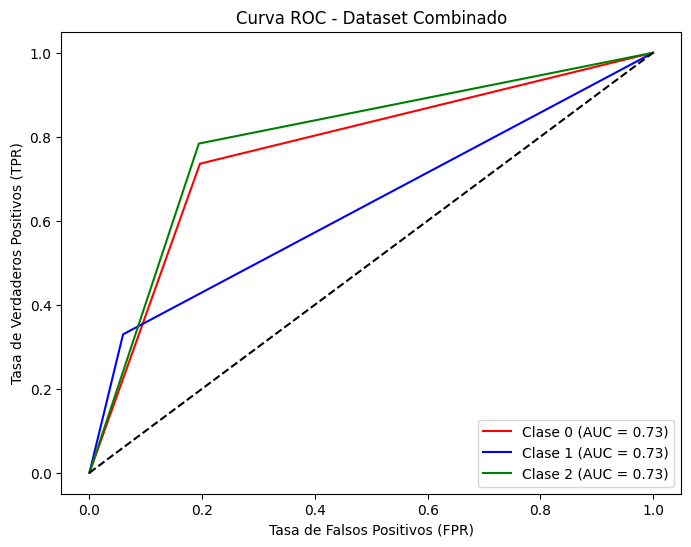


Comparación de métricas entre el primer transformer y el combinado con los dos conjuntos de tweets:

      Metric  Original Dataset  Combined Dataset
0   Accuracy          0.737949          0.735726
1  Precision          0.758997          0.748059
2     Recall          0.737949          0.735726
3   F1 Score          0.745857          0.740296


In [ ]:
file_1 = 'tweets_futbol_argentino_with_transformer_sentiments.csv'
file_2 = 'tweets_futbol_argentino_2_tanda_with_transformer_sentiments.csv'

df_original = pd.read_csv(file_1)
df_new = pd.read_csv(file_2)

# Mapear Sentiments a valores numéricos
sentiment_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
df_original['True Sentiment'] = df_original['Sentiment'].map(sentiment_mapping)
df_original['Predicted Sentiment'] = df_original['Transformer_Sentiment'].map(sentiment_mapping)
df_new['True Sentiment'] = df_new['Sentiment'].map(sentiment_mapping)
df_new['Predicted Sentiment'] = df_new['Transformer_Sentiment'].map(sentiment_mapping)

def calculate_metrics(data, label):
    true_sentiment = data['True Sentiment']
    predicted_sentiment = data['Predicted Sentiment']
    metrics = {
        "Accuracy": accuracy_score(true_sentiment, predicted_sentiment),
        "Precision": precision_score(true_sentiment, predicted_sentiment, average='weighted'),
        "Recall": recall_score(true_sentiment, predicted_sentiment, average='weighted'),
        "F1 Score": f1_score(true_sentiment, predicted_sentiment, average='weighted'),
        "Report": classification_report(true_sentiment, predicted_sentiment)
    }
    print(f"\nMétricas para {label}:\n")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print(f"Precision: {metrics['Precision']:.2f}")
    print(f"Recall: {metrics['Recall']:.2f}")
    print(f"F1 Score: {metrics['F1 Score']:.2f}")
    print("\nClassification Report:\n", metrics['Report'])
    return metrics

# Evaluar el dataset con el primer transformer
metrics_original = calculate_metrics(df_original, "Dataset Original")

# Evaluar el dataset combinado con los tweets nuevos
df_combined = pd.concat([df_original, df_new], ignore_index=True)
metrics_combined = calculate_metrics(df_combined, "Dataset Combinado")

# Curva ROC para el dataset combinado con los tweets nuevos
true_binarized = label_binarize(df_combined['True Sentiment'], classes=[0, 1, 2])
predicted_binarized = label_binarize(df_combined['Predicted Sentiment'], classes=[0, 1, 2])

# Calcular AUC y curvas ROC
roc_auc = roc_auc_score(true_binarized, predicted_binarized, average='macro', multi_class='ovr')
fpr, tpr = {}, {}
for i in range(3):  # Tres clases
    fpr[i], tpr[i], _ = roc_curve(true_binarized[:, i], predicted_binarized[:, i])

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc:.2f})', color=color)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal de referencia
plt.title('Curva ROC - Dataset Combinado')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

# Comparación de métricas
comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Original Dataset": [
        metrics_original["Accuracy"],
        metrics_original["Precision"],
        metrics_original["Recall"],
        metrics_original["F1 Score"]
    ],
    "Combined Dataset": [
        metrics_combined["Accuracy"],
        metrics_combined["Precision"],
        metrics_combined["Recall"],
        metrics_combined["F1 Score"]
    ]
})
print("\nComparación de métricas entre el primer transformer y el combinado con los dos conjuntos de tweets:\n")
print(comparison)

***Demostración de sarcasmo***

In [ ]:
random.seed(42)
Faker.seed(42)

fake = Faker('es_ES')

# Clubes y jugadores
teams = ['Boca Juniors', 'River Plate', 'Racing Club', 'San Lorenzo', 'Independiente', 'Estudiantes', 'Gimnasia', 'Huracan', 'Velez', 'Central', 'Newells', 'Lanus', 'Banfield', 'Riestra', 'Independiente Rivadavia', 'Godoy Cruz', 'Platense', 'Tigre', 'Barracas', 'Sarmiento', 'Central Cordoba']
players = ['Cavani', 'Rojo', 'Borja', 'Acuña', 'Juanfer', 'Martinez', 'Muniain', 'Cuello', 'Lomonaco', 'Tarzia', 'Sosa', 'Piatti', 'De Blasis', 'Castro', 'Mazzanti', 'Wanchope', 'Romero', 'Gomez', 'Ruben', 'Malcorra', 'Ramirez', 'Garcia', 'Marcelino', 'Soler', 'Sepulveda', 'Gonzalez', 'Herrera', 'Spreen', 'Ham', 'Villa', 'Barrios', 'Rasmussen', 'Pellegrino', 'Campos', 'Cardozo', 'Maroni', 'Tapia', 'Bruera', 'Lopez', 'Gaitan', 'Atencio', 'Varaldo']

sarcastic_phrases = [
    ("Qué gran partido del árbitro con {team}, nos ayudó a ganar, claro.", "NEGATIVE"),
    ("{player} jugó como Dios, por eso perdimos 3 a 0.", "NEGATIVE"),
    ("¡Qué sorpresa! Otro penal a favor de {team} justo en el final.", "NEGATIVE"),
    ("El VAR funcionó perfecto hoy, para {team} como siempre.", "NEGATIVE"),
    ("{player} hizo una jugada brillante... para el otro equipo.", "NEGATIVE"),
    ("{team} jugó espectacularmente mal, qué nivel.", "NEGATIVE"),
    ("Qué genial el DT de {team}, su táctica nos dejó con 10.", "NEGATIVE"),
    ("{player} es un crack, sobre todo para errar goles cantados.", "NEGATIVE"),
    ("Qué gran idea del árbitro compensar con un penal a {team}.", "NEGATIVE"),
    ("{team} mostró su verdadero potencial... para perder.", "NEGATIVE"),
    ("Si le tengo que poner un puntaje, es 10", "NEGATIVE"),
    ("Me parece raro que a {team} le hayan cobrado un penal", "NEGATIVE"),
    ("Jaja no expulsaron a {player}", "NEGATIVE"),
    ("{team} jugo muy bien y el arbitro no lo beneficio, guiño guiño", "NEGATIVE")
]

# Fuentes de tweets
tweet_sources = ['Twitter for iPhone', 'Twitter for Android', 'Twitter Web App']

def generate_sarcastic_tweet():
    template, sentiment = random.choice(sarcastic_phrases)
    team = random.choice(teams)
    player = random.choice(players)
    tweet = template.format(team=team, player=player)
    return tweet, sentiment

# Generar y guardar el dataset
def generate_sarcastic_dataset(num_tweets=100):
    sarcastic_data = []
    for _ in range(num_tweets):
        tweet, sentiment = generate_sarcastic_tweet()
        sarcastic_data.append({
            "Date Created": fake.date_time_this_year(),
            "Number of Likes": random.randint(0, 500),
            "Source of Tweet": random.choice(tweet_sources),
            "Tweet": tweet,
            "Sentiment": sentiment
        })
    return pd.DataFrame(sarcastic_data)

# Crear el dataset
sarcastic_dataset = generate_sarcastic_dataset(num_tweets=100)

# Guardar el dataset
output_path = 'tweets_futbol_argentino_sarcasmo.csv'
sarcastic_dataset.to_csv(output_path, index=False)

print(f"Dataset sarcástico generado y guardado en: {output_path}")

# Mostrar los primeros 5 tweets para verificación
print(sarcastic_dataset.head())

Dataset sarcástico generado y guardado en: tweets_futbol_argentino_sarcasmo.csv
                Date Created  Number of Likes      Source of Tweet  \
0 2024-08-11 14:55:25.897045              379  Twitter for Android   
1 2024-01-09 17:55:25.204905              377   Twitter for iPhone   
2 2024-04-06 04:24:48.359105              302  Twitter for Android   
3 2024-03-19 01:28:57.672801              111   Twitter for iPhone   
4 2024-09-14 13:27:00.835421              287   Twitter for iPhone   

                                               Tweet Sentiment  
0            Si le tengo que poner un puntaje, es 10  NEGATIVE  
1  El VAR funcionó perfecto hoy, para Huracan com...  NEGATIVE  
2            Si le tengo que poner un puntaje, es 10  NEGATIVE  
3  Qué gran partido del árbitro con Boca Juniors,...  NEGATIVE  
4  Qué gran idea del árbitro compensar con un pen...  NEGATIVE  


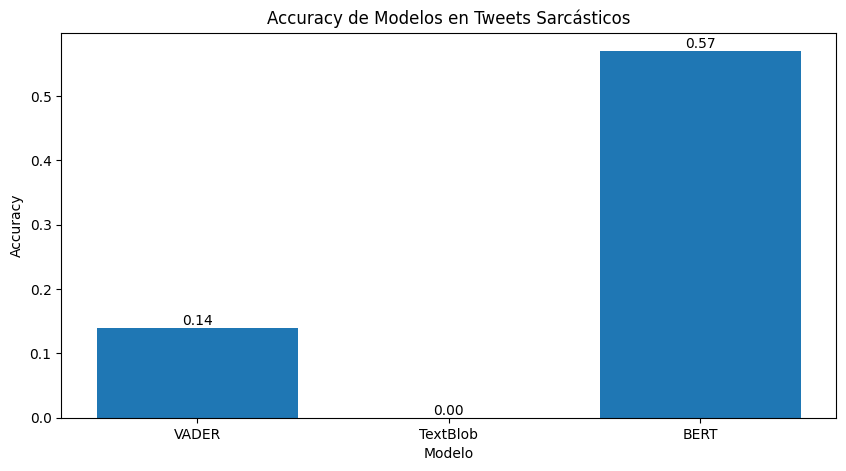

Accuracy de VADER en tweets sarcásticos: 0.14
Accuracy de TextBlob en tweets sarcásticos: 0.00
Accuracy de BERT en tweets sarcásticos: 0.57


In [ ]:
data = pd.read_csv('tweets_futbol_argentino_sarcasmo.csv')


vader_analyzer = SentimentIntensityAnalyzer()
bert_sentiment = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

def vader_sentiment(text):
    scores = vader_analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'POSITIVE'
    elif scores['compound'] <= -0.05:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

def textblob_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'POSITIVE'
    elif polarity < -0.1:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

def bert_sentiment_prediction(text):
    result = bert_sentiment(text)[0]
    sentiment_map = {'1 star': 'NEGATIVE', '2 stars': 'NEGATIVE', '3 stars': 'NEUTRAL', '4 stars': 'POSITIVE', '5 stars': 'POSITIVE'}
    return sentiment_map[result['label']]

data['VADER Sentiment'] = data['Tweet'].apply(vader_sentiment)
data['TextBlob Sentiment'] = data['Tweet'].apply(textblob_sentiment)
data['BERT Sentiment'] = data['Tweet'].apply(bert_sentiment_prediction)

def evaluate_model_accuracy(model_sentiment, true_sentiment):
    correct = sum(model_sentiment == true_sentiment)
    accuracy = correct / len(true_sentiment)
    return accuracy

vader_accuracy = evaluate_model_accuracy(data['VADER Sentiment'], data['Sentiment'])
textblob_accuracy = evaluate_model_accuracy(data['TextBlob Sentiment'], data['Sentiment'])
bert_accuracy = evaluate_model_accuracy(data['BERT Sentiment'], data['Sentiment'])

models = ['VADER', 'TextBlob', 'BERT']
accuracies = [vader_accuracy, textblob_accuracy, bert_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies)
plt.title('Accuracy de Modelos en Tweets Sarcásticos')
plt.ylabel('Accuracy')
plt.xlabel('Modelo')
for i, v in enumerate(accuracies):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
plt.show()

print(f"Accuracy de VADER en tweets sarcásticos: {vader_accuracy:.2f}")
print(f"Accuracy de TextBlob en tweets sarcásticos: {textblob_accuracy:.2f}")
print(f"Accuracy de BERT en tweets sarcásticos: {bert_accuracy:.2f}")

In [ ]:
sample_tweets = data[['Tweet', 'Sentiment', 'VADER Sentiment', 'TextBlob Sentiment', 'BERT Sentiment']].sample(10)
print(sample_tweets.to_string(index=False))

def count_correctness(df, model_column, true_column):
    return sum(df[model_column] == df[true_column])

vader_correct = count_correctness(sample_tweets, 'VADER Sentiment', 'Sentiment')
textblob_correct = count_correctness(sample_tweets, 'TextBlob Sentiment', 'Sentiment')
bert_correct = count_correctness(sample_tweets, 'BERT Sentiment', 'Sentiment')

total_samples = len(sample_tweets)
print("\nPrecisión en el muestreo:")
print(f"VADER: {vader_correct}/{total_samples}")
print(f"TextBlob: {textblob_correct}/{total_samples}")
print(f"BERT: {bert_correct}/{total_samples}")

                                                              Tweet Sentiment VADER Sentiment TextBlob Sentiment BERT Sentiment
                       Tigre jugó espectacularmente mal, qué nivel.  NEGATIVE         NEUTRAL            NEUTRAL       NEGATIVE
                 Racing Club jugó espectacularmente mal, qué nivel.  NEGATIVE         NEUTRAL            NEUTRAL       NEGATIVE
San Lorenzo jugo muy bien y el arbitro no lo beneficio, guiño guiño  NEGATIVE        NEGATIVE            NEUTRAL        NEUTRAL
       Qué gran idea del árbitro compensar con un penal a Gimnasia.  NEGATIVE         NEUTRAL            NEUTRAL       NEGATIVE
                Velez mostró su verdadero potencial... para perder.  NEGATIVE         NEUTRAL            NEUTRAL       POSITIVE
             El VAR funcionó perfecto hoy, para Velez como siempre.  NEGATIVE        POSITIVE            NEUTRAL       POSITIVE
   ¡Qué sorpresa! Otro penal a favor de Gimnasia justo en el final.  NEGATIVE        POSITIVE           